# Clustering analysis with Adversarial Autoencoders

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize, to_categorical
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os

from imp import load_source
from utils import plot_results_pca, plot_results_umap, plot_results_louvain
from models import *

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## Adversarial Autoencoder: Unsupervised Model

### Build the model

In [4]:
# Network parameters

layers_dim_enc = [100,50,50]
layers_dim_dec = [50,50,100]
layers_dim_dis = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE1(latent_dim, 
             [layers_dim_enc, layers_dim_dec, layers_dim_dis],
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [9]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
latent_dim,50,dimension of latent space Z
layer_1_enc_dim,100,dimension of encoder dense layer 1
layer_2_enc_dim,50,dimension of encoder dense layer 2
layer_3_enc_dim,50,dimension of encoder dense layer 3
layer_1_dec_dim,50,dimension of decoder dense layer 1
layer_2_dec_dim,50,dimension of decoder dense layer 2
layer_3_dec_dim,100,dimension of decoder dense layer 3
layer_1_dis_dim,50,dimension of discriminator dense layer 1
layer_2_dis_dim,50,dimension of discriminator dense layer 2
layer_3_dis_dim,100,dimension of discriminator dense layer 3


In [10]:
# Build the full model

model.build_model()

In [11]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1789)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          178900      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [13]:
# Export model graphs

os.makedirs('../graphs', exist_ok=True)
model.export_graph('../graphs')

Model graphs saved.




ENCODER


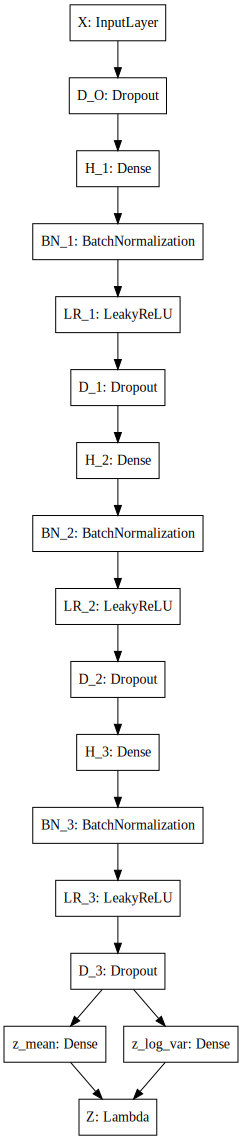

In [16]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


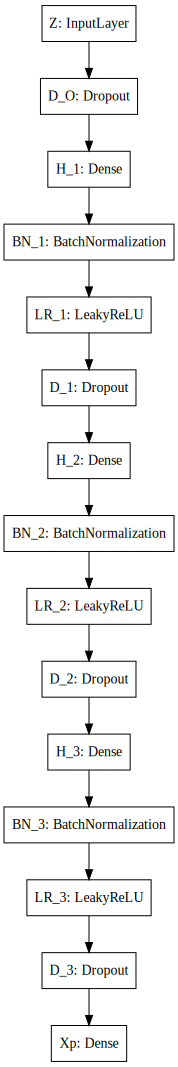

In [17]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


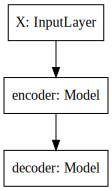

In [18]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


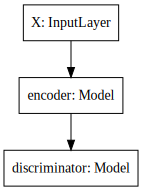

In [23]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


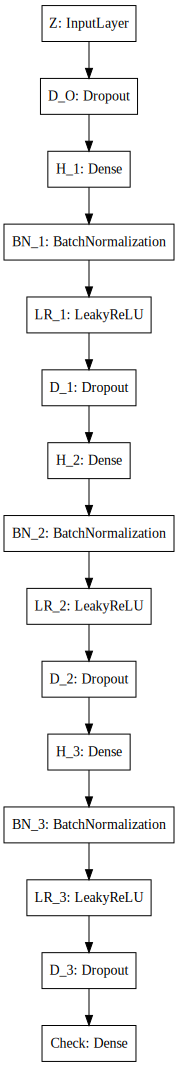

In [19]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Model training

Epoch 50/50, reconstruction loss: 0.912380, generation loss: 0.435545, discriminator loss: 0.285745


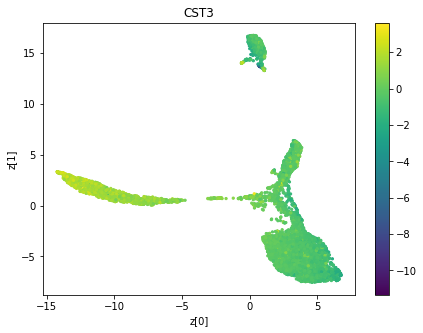

Training completed.


In [14]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, disc_loss = model.train(graph=True, gene=gene)

In [16]:
# save models in h5 format
os.makedirs('../models', exist_ok=True)
model.export_model('../models')

Adversarial Autoencoder networks exported in h5 format.


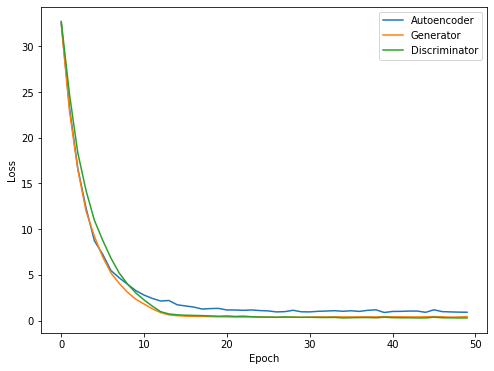

In [17]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(disc_loss)
#axes.set_xlim([xmin,xmax])
#axes.set_ylim([570,700])
#plt.loglog()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

models = (model.encoder, model.decoder)
gene_list = ['CST3', 'NKG7', 'PPBP']
plot_results_pca(models, model.data, gene_list, model.gene_list, model.latent_dim)

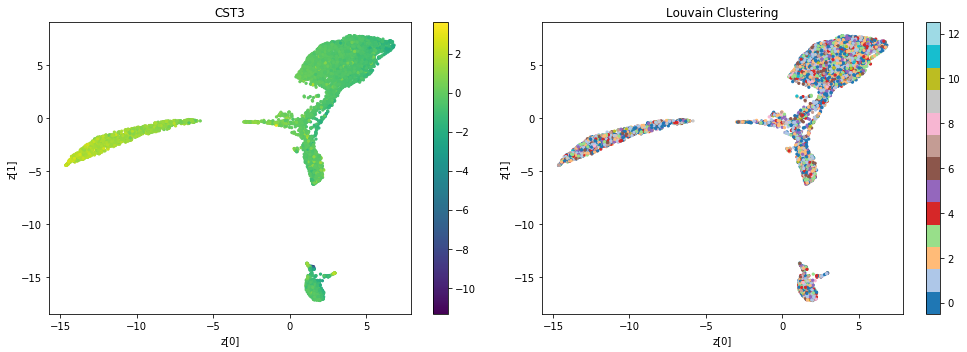

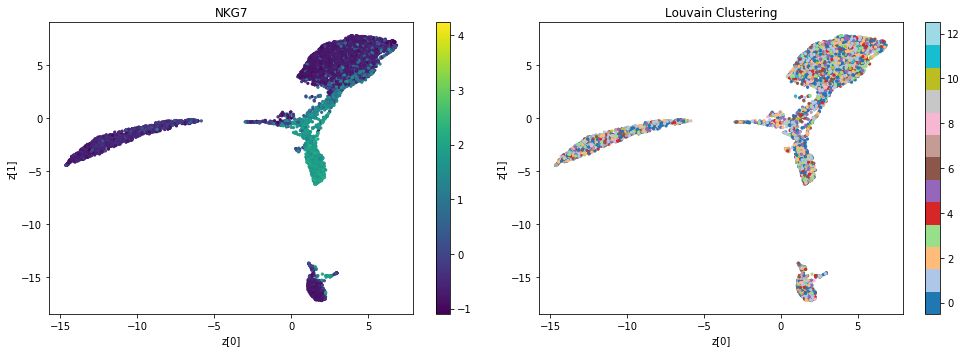

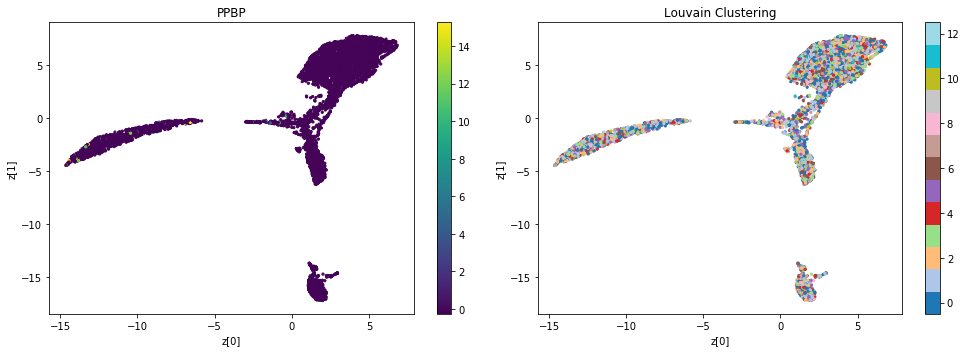

In [18]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)